In [1]:
#Import 
import warnings; warnings.simplefilter('ignore') #for PCoA warnings
import pandas as pd
import numpy as np
import random
import itertools
#import data
from biom import load_table
from gneiss.util import match
#plotting
import seaborn as sns
import matplotlib.pyplot as plt
#MOCK data generation
from gneiss import util
#biplots
from sklearn.datasets import samples_generator as sg
from sklearn.cluster.bicluster import SpectralBiclustering
#from sklearn.metrics import consensus_score
from sklearn.utils import shuffle
from sklearn.metrics import mean_squared_error
#completions
from DEICODE.untangle import complete_matrix,machine_learning,biplot
from fancyimpute import BiScaler, KNN, NuclearNormMinimization, SoftImpute,IterativeSVD,MICE,MatrixFactorization
#transforms 
from skbio.stats.composition import clr,ilr
#PCoA
from skbio import DistanceMatrix
from skbio.stats.ordination import pcoa
from scipy.spatial.distance import pdist, squareform
from skbio.stats import subsample_counts
# Intials
rand = np.random.RandomState(42)
fnts=12
# make it look nice
sns.set(font="monospace")
import warnings
warnings.filterwarnings("ignore")
from IPython.core.display import HTML
plt.style.use('fivethirtyeight')
plt.style.use('seaborn-white')
plt.style.use('seaborn-darkgrid')
plt.style.use('seaborn-paper')
HTML("""<style>div.cell { /* Tunes the space between cells */margin-top:1em;margin-bottom:1em;}div.text_cell_render h1 { /* Main titles bigger, centered */
font-size: 3em;line-height:1.4em;text-align:center;}
div.text_cell_render h2 { /*  Parts names nearer from text */margin-bottom: -0.4em;}
div.text_cell_render { /* Customize text cells */font-family: 'Times New Roman';font-size:1.2em;line-height:1.4em;
padding-left:3em;padding-right:3em;}</style>""")
%matplotlib inline

In [2]:
def block_diagonal(ncols, nrows, nblocks,minval=0,maxval=1.0):
    """ Generate block diagonal with uniformly distributed values within blocks.
    Parameters
    ----------
    ncol : int
        Number of columns
    nrows : int
        Number of rows
    nblocks : int
        Number of blocks
    Returns
    -------
    np.array
        Table with a block diagonal where the rows represent samples
        and the columns represent features.  The values within the blocks
        are uniformly distributed between 0 and 1.
    Note
    ----
    The number of blocks specified by `nblocks` needs to be greater than 1.
    """
    if nblocks <= 1:
        raise ValueError('`nblocks` needs to be greater than 1.')
    mat = np.zeros((nrows, ncols))
    block_cols = ncols // nblocks
    block_rows = nrows // nblocks
    for b in range(nblocks-1):
        B = np.random.uniform(minval,maxval,size=(block_rows, block_cols))
        lower_row = block_rows * b
        upper_row = min(block_rows*(b+1), nrows)
        lower_col = block_cols * b
        upper_col = min(block_cols*(b+1), ncols)

        mat[lower_row:upper_row, lower_col:upper_col] = B

    # Make last block fill in the remainder
    B = np.random.uniform(minval,maxval,size=(nrows-upper_row, ncols-upper_col))
    mat[upper_row:, upper_col:] = B
    return mat


In [3]:
def plot_pcoa(otupcoadfs,mapping,catvis,fig_fontsize=18,suptit_=None,method='braycurtis'):
    
    if  all(isinstance(item, str) for item in list(mapping.T[catvis])) or all(isinstance(item, bool) for item in list(mapping.T[catvis])):
        if len(otupcoadfs)==1:
            fig, ax1 = plt.subplots(ncols=1, nrows=1, figsize=(8, 8)) 
            otupcoadf=otupcoadfs[0]
            title='Mean Sequences Per Sample:'+str(np.mean(otupcoadf.sum())).split('.')[0]
            pcaplot=pcoa(DistanceMatrix(pdist(otupcoadf.as_matrix().T,method),list(otupcoadf.columns))).samples[['PC1','PC2','PC3']]
            pcaplot[catvis]=list(mapping.T[catvis])
            for ((key, grp)) in pcaplot.groupby(catvis):
                ax1.scatter(grp['PC1'], grp['PC2'], color=next(ax1._get_lines.prop_cycler)['color'], label=key, s=50)
            ax1.set_xticks([])
            ax1.set_yticks([])
            ax1.legend(loc=2,prop={'size':16},bbox_to_anchor=(1.0, 1.0))
            ax1.set_title(title,fontsize=fig_fontsize,y=1.05)
            ax1.set_ylabel('$PC-1$',fontsize=fig_fontsize-2)
            ax1.set_xlabel('$PC-2$',fontsize=fig_fontsize-2) 
            if suptit_!=None:
                plt.suptitle(suptit_,y=1.05,fontsize=fig_fontsize+8)
            return fig

        else:
            fig, axn = plt.subplots(ncols=len(otupcoadfs), nrows=1, figsize=(15, 5)) 

            for ax1,(count_,otupcoadf) in zip(axn.flat,enumerate(otupcoadfs)):
                title=str(np.mean(otupcoadf.sum())).split('.')[0]+' Sequences Per Sample'
                pcaplot=pcoa(DistanceMatrix(pdist(otupcoadf.as_matrix().T,method),list(otupcoadf.columns))).samples[['PC1','PC2','PC3']]
                pcaplot[catvis]=list(mapping.T[catvis])
                for ((key, grp)) in pcaplot.groupby(catvis):
                    ax1.scatter(grp['PC1'], grp['PC2'], color=next(ax1._get_lines.prop_cycler)['color'], label=key, s=50)
                ax1.set_xticks([])
                ax1.set_yticks([])
                if count_==len(otupcoadfs)-1:
                    ax1.legend(loc=2,prop={'size':16},bbox_to_anchor=(1.0, 1.0))
                ax1.set_title(title,fontsize=fig_fontsize,y=1.05)
                ax1.set_ylabel('$PC-1$',fontsize=fig_fontsize-2)
                ax1.set_xlabel('$PC-2$',fontsize=fig_fontsize-2) 
            if suptit_!=None:
                plt.suptitle(suptit_,y=1.05,fontsize=fig_fontsize+8)
            return fig
    
    else:
        if len(otupcoadfs)==1:
            otupcoadf=otupcoadfs[0]
            pcaplot=pcoa(DistanceMatrix(pdist(otupcoadf.as_matrix().T,method),list(otupcoadf.columns))).samples[['PC1','PC2','PC3']]
            pcaplot[catvis]=list(mapping.T[catvis])
            fig, (ax1) = plt.subplots(ncols=1, nrows=1, figsize=(8, 6),sharey=False)
            pcaplot.plot.scatter(x='PC1', y='PC2', c=str(catvis),cmap='RdBu_r', s=50,ax=ax1);
            ax1.set_xlabel('$PC-1$')
            ax1.set_ylabel('$PC-2$')
            ax1.set_xticks([])
            ax1.set_yticks([])
            return fig 
        else:
            fig, axn = plt.subplots(ncols=len(otupcoadfs), nrows=1, figsize=(15, 5)) 
            for ax1,(count_,otupcoadf) in zip(axn.flat,enumerate(otupcoadfs)):
                title=str(np.mean(otupcoadf.sum())).split('.')[0]+' Sequences Per Sample'
                pcaplot=pcoa(DistanceMatrix(pdist(otupcoadf.as_matrix().T,method),list(otupcoadf.columns))).samples[['PC1','PC2','PC3']]
                pcaplot[catvis]=list(mapping.T[catvis])
                pcaplot.plot.scatter(x='PC1', y='PC2', c=str(catvis),cmap='RdBu_r', s=50,ax=ax1);
                ax1.set_xlabel('$PC-1$')
                ax1.set_ylabel('$PC-2$')
                ax1.set_xticks([])
                ax1.set_yticks([])
                ax1.set_title(title,fontsize=fig_fontsize,y=1.05)
            return fig 

In [4]:
def add_noise(X_true,hoced=None,hsced=None,inten=None,spar=None):
    
    '''
    This function, induces sparcity and then can add Heteroscedastic or Homoscedastic noise at desried levels.
    
    
    hoced, float [0,1]
    The percentage of homoscedastic noise 
    
    hsced, float [0,1]
    The percentage of Heteroscedastic noise 
    
    inten, float
    The max value of the noise   
    
    spar, float
    The percentage of density desired, min is zero but no max
    
    '''
    X_noise=X_true.copy()
    
    # Induce low-density into the matrix
    if spar is not None:
        X_noise=np.array(X_noise)
        mask = np.random.randint(0,spar,size=X_noise.shape).astype(np.bool)
        rand_zeros = np.random.rand(*X_noise.shape)*0
        X_noise[mask] = rand_zeros[mask]
    
    
    # add Homoscedastic noise
    if hoced is not None:
        err = hoced * np.ones_like(X_noise.copy())
        X_noise = rand.normal(X_noise.copy(), err)
    
    # add Heteroscedastic noise
    if hsced is not None:
        err = hsced * np.ones_like(X_noise)
        i = rand.randint(0, err.shape[0], 5000)
        j = rand.randint(0, err.shape[1], 5000)
        err[i, j] = inten
        X_noise = abs(rand.normal(X_noise, err))


    #return the noisy data 
    return pd.DataFrame(X_noise,columns=X_true.columns,index=X_true.index)   

## 88 soils real dataset 

In [5]:
# import observation data
in_biom='data/benchmarking/88soils.biom' #import biom file
table = load_table(in_biom)
read_filter = lambda val, id_, md: sum(val) > 0
read_filter_s = lambda val, id_, md: sum(val) > 500
table.filter(read_filter_s, axis='sample')
table.filter(read_filter, axis='observation')
otutabledf=table.to_dataframe()
otutabledf=otutabledf.T
otutabledf.drop_duplicates(inplace=True)

# Get OTU to taxa match
taxonomy=table.metadata_to_dataframe('observation')
taxonomy.columns=['kingdom', 'phylum', 'class', 'order', 
                             'family', 'genus', 'species']
taxonomy['taxonomy'] = taxonomy[taxonomy.columns].apply(lambda x: ';'.join(x), axis=1)

#mapping import 
map_file='data/benchmarking/88soils.txt' #import metadata
mappingdf= pd.read_table('%s'%map_file, index_col=0,low_memory=False)
mappingdf=mappingdf.replace(np.nan,'Unknown', regex=True)
mappingdf.index=list(map(str,mappingdf.index))
mappingdf=mappingdf.astype(str)
mappingdf=mappingdf[~mappingdf.index.duplicated(keep='first')]

#match the tables
otutabledf,mappingdf=match(otutabledf,mappingdf)

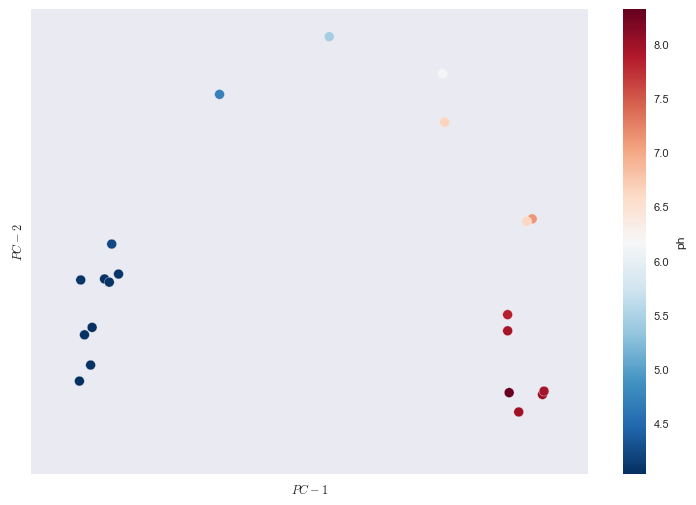

In [6]:
#plot data
mappingdf=mappingdf.apply(pd.to_numeric, errors='ignore')
fig=plot_pcoa([otutabledf.T],mappingdf.T,'ph',method='jaccard')
plt.show()

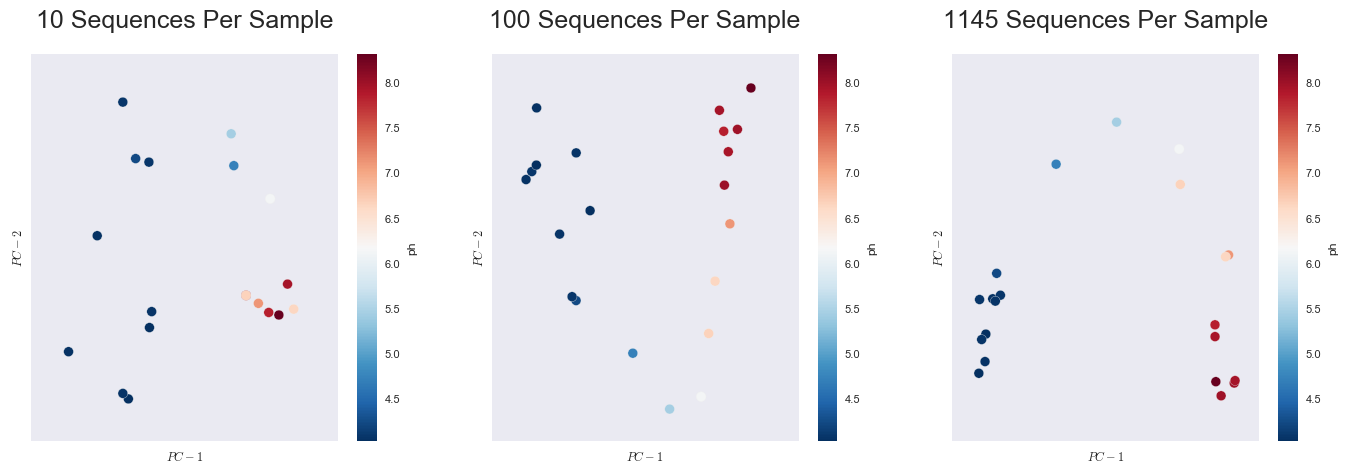

In [7]:
# sub sample 
Subsamples_noisy=[]
for sub_ in [10,100]:
      
    X_sub=otutabledf.T.fillna(0).astype(int).copy()
    #sub samples
    for column_ in X_sub.columns:
        X_sub[column_]=subsample_counts(X_sub[column_].values, sub_)

    Subsamples_noisy.append(X_sub)
    
Subsamples_noisy.append(otutabledf.T.fillna(0).astype(int).copy())
#plot data1
mappingdf=mappingdf.apply(pd.to_numeric, errors='ignore')
fig=plot_pcoa(Subsamples_noisy,mappingdf.T,'ph',method='jaccard')
plt.show()

In [8]:
%%capture capt
X_recovered_psuedo=[]
X_recovered_opt=[]
X_recovered_soft=[]
X_recovered_knn=[]
X_recovered_itersvd=[]

for X_noise_subsampled in Subsamples_noisy:
    
    #psuedo count
    X_recovered_psuedo.append(X_noise_subsampled.as_matrix()+1)
    
    # OptSpace
    X_filled_opt=complete_matrix(X_noise_subsampled.as_matrix().copy(),rank=3,iteration=20,minval=.01,maxval=1)  
    X_recovered_opt.append(pd.DataFrame(X_filled_opt,X_noise_subsampled.index,X_noise_subsampled.columns))
    
    # Make 0 NaN for fancy impute 
    X_noisefancy=X_noise_subsampled.astype(float).as_matrix().copy()
    X_noisefancy[X_noisefancy==0]=np.nan
    
    # KNN
    X_filled_knn = KNN(k=20,verbose=False,max_value=1,min_value=.01).complete(X_noisefancy)
    X_recovered_knn.append(pd.DataFrame(X_filled_knn,X_noise_subsampled.index,X_noise_subsampled.columns))
    
    #soft impute
    X_filled_softimpute = SoftImpute(verbose=False,max_value=1,min_value=.01).complete(X_noisefancy)
    X_recovered_soft.append(pd.DataFrame(X_filled_softimpute,X_noise_subsampled.index,X_noise_subsampled.columns))
    
    # Iter SVD
    X_filled_iter=IterativeSVD(verbose=False,max_value=1,min_value=.01).complete(X_noisefancy)
    X_recovered_itersvd.append(pd.DataFrame(X_filled_iter,X_noise_subsampled.index,X_noise_subsampled.columns))

In [9]:
mse_psuedo=[]
mse_opt=[]
mse_soft=[]
mse_knn=[]
mse_itersvd=[]

for count_,subsampled_with_zeros in enumerate(Subsamples_noisy):
    
    mse_psuedo.append(mean_squared_error(subsampled_with_zeros, X_recovered_psuedo[count_]))
    mse_opt.append(mean_squared_error(subsampled_with_zeros, X_recovered_opt[count_]))
    mse_soft.append(mean_squared_error(subsampled_with_zeros, X_recovered_soft[count_]))
    mse_knn.append(mean_squared_error(subsampled_with_zeros, X_recovered_knn[count_]))
    mse_itersvd.append(mean_squared_error(subsampled_with_zeros, X_recovered_itersvd[count_]))  

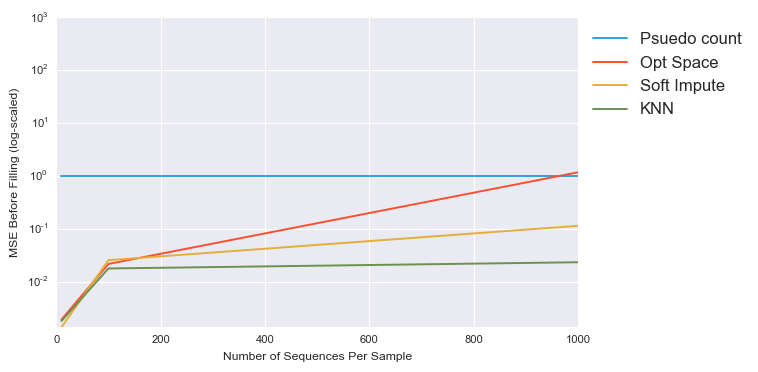

In [10]:
plt.plot([10,100,1000],mse_psuedo, label='Psuedo count')
plt.plot([10,100,1000],mse_opt, label='Opt Space')
plt.plot([10,100,1000],mse_soft, label='Soft Impute')
plt.plot([10,100,1000],mse_knn, label='KNN')
plt.legend(loc=2,prop={'size':12},bbox_to_anchor=(1.0, 1.0))
plt.yscale('log')
plt.ylim(0,1000)
plt.ylabel('MSE Before Filling (log-scaled)')
plt.xlabel('Number of Sequences Per Sample')
plt.show()

# Simulate band

## visualize three points 10, 100, 1000, and 10000 seq persample 

In [33]:
from gneiss.util import band_diagonal

In [34]:
### generate data ### 
n=100 # number of columns (Samples)
b=2 # number of rows (OTUS)
# make a mock OTU table
band=band_diagonal(b=2,n=n)*1000000
samples,features=band.shape[0],band.shape[1]
# make a mock df
X_true=pd.DataFrame(band.T,columns=['sample_'+str(x) for x in range(0,samples)],index=['OTU_'+str(x) for x in range(0,(features))])
# make a mock mapping data
mapping=pd.DataFrame(np.array([x for x in range(0,n)]),columns=['example'],index=['sample_'+str(x) for x in range(0,n)])
#get noise to mimic real datasets 
X_noise=add_noise(X_true,10,10,10,1)
X_noise=X_noise.astype(int)

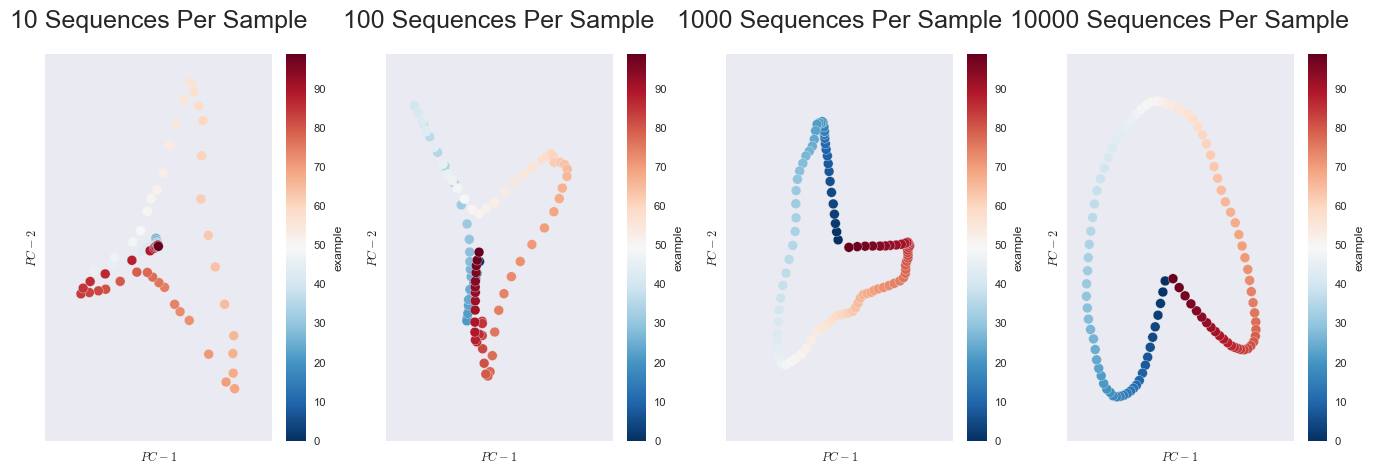

In [35]:
# sub sample 
Subsamples_noisy=[]
for sub_ in [10,100,1000,10000]:
      
    X_noise_sub=X_noise.copy()
    #sub samples
    for column in X_noise_sub.columns:
        X_noise_sub[column]=subsample_counts(X_noise_sub.astype(int)[column].values, sub_)
    
    Subsamples_noisy.append(X_noise_sub)
    
#plot data
fig=plot_pcoa(Subsamples_noisy,mapping.T,'example')
plt.show()

In [36]:
%%capture capt
X_recovered_psuedo=[]
X_recovered_opt=[]
X_recovered_soft=[]
X_recovered_knn=[]
X_recovered_itersvd=[]

for X_noise_subsampled in Subsamples_noisy:
    
    #psuedo count
    X_recovered_psuedo.append(pd.DataFrame(X_noise_subsampled+1,X_noise_subsampled.index,X_noise_subsampled.columns))
    
    # OptSpace
    X_filled_opt=complete_matrix(X_noise_subsampled.as_matrix().copy(),rank=30,iteration=20,minval=.01,maxval=1)  
    X_recovered_opt.append(pd.DataFrame(X_filled_opt,X_noise_subsampled.index,X_noise_subsampled.columns))
    
    # Make 0 NaN for fancy impute 
    X_noisefancy=X_noise_subsampled.copy()
    X_noisefancy[X_noisefancy==0]=np.nan
    
    # KNN
    X_filled_knn = KNN(k=20,verbose=False,max_value=1,min_value=.01).complete(X_noisefancy)
    X_recovered_knn.append(pd.DataFrame(X_filled_knn,X_noise_subsampled.index,X_noise_subsampled.columns))
    
    #soft impute
    X_filled_softimpute = SoftImpute(verbose=False,max_value=1,min_value=.01).complete(X_noisefancy)
    X_recovered_soft.append(pd.DataFrame(X_filled_softimpute,X_noise_subsampled.index,X_noise_subsampled.columns))
    
    # Iter SVD
    X_filled_iter=IterativeSVD(verbose=False,max_value=1,min_value=.01).complete(X_noisefancy)
    X_recovered_itersvd.append(pd.DataFrame(X_filled_iter,X_noise_subsampled.index,X_noise_subsampled.columns))

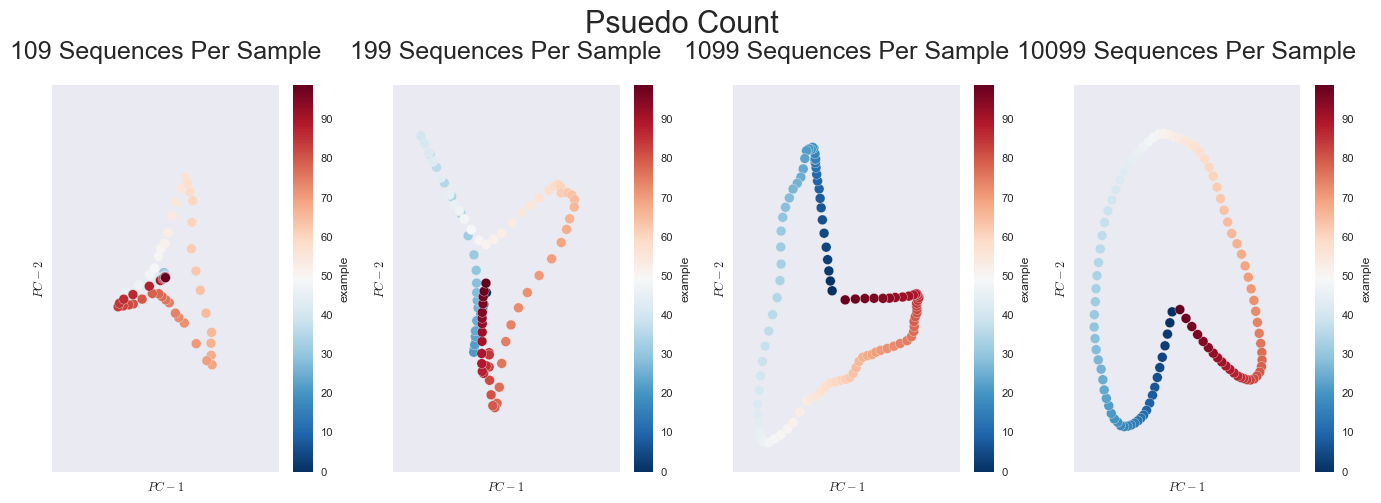

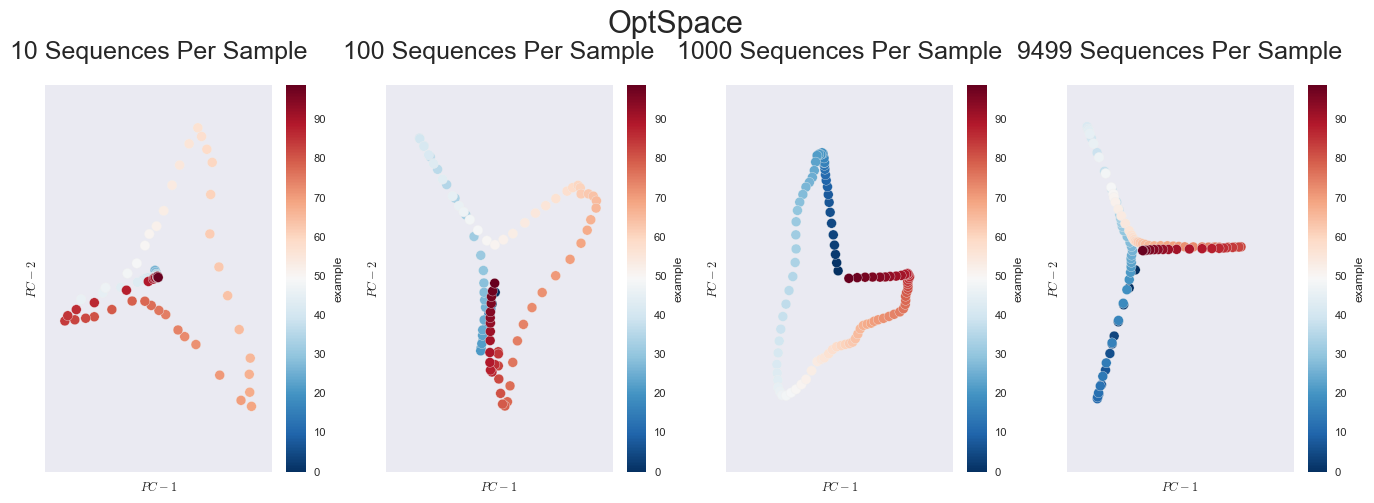

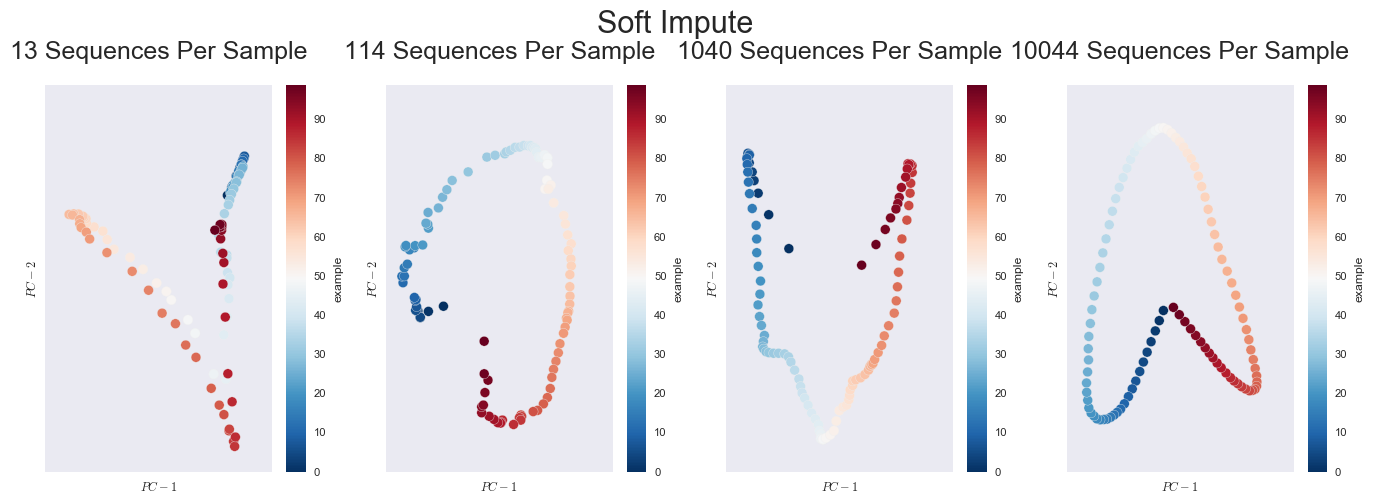

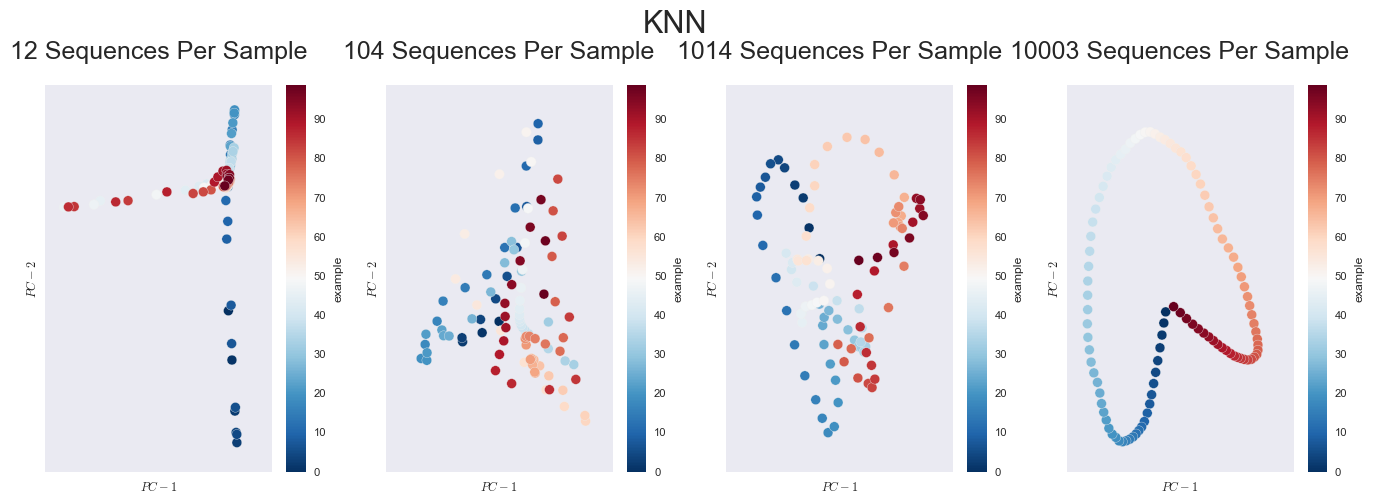

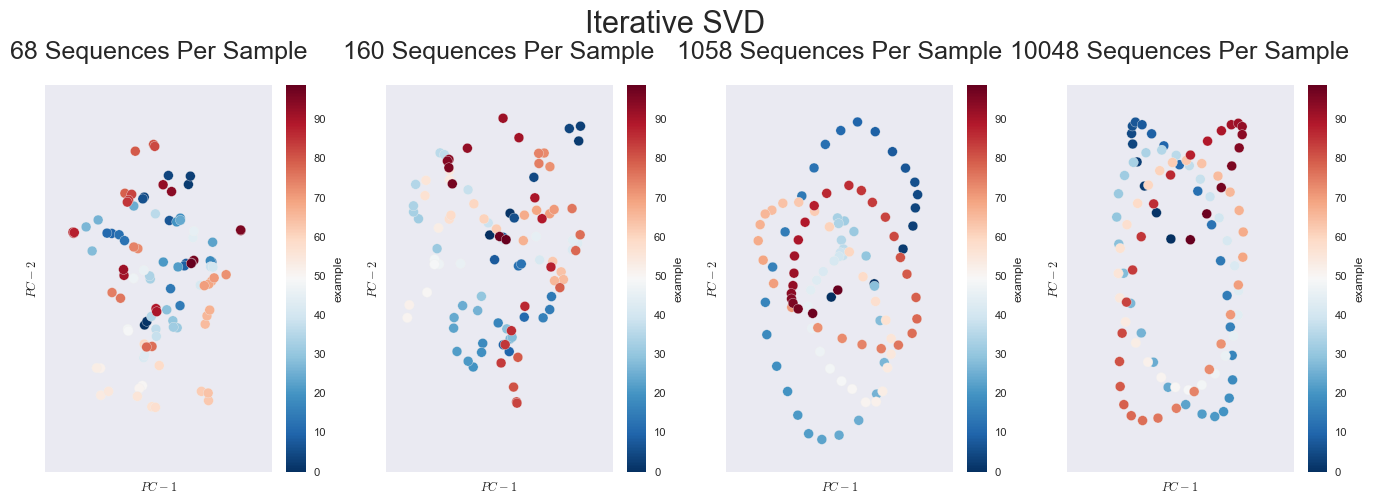

In [37]:
for X_recovered,suptit_ in zip([X_recovered_psuedo,X_recovered_opt,X_recovered_soft,X_recovered_knn,X_recovered_itersvd],
                       ['Psuedo Count','OptSpace','Soft Impute','KNN','Iterative SVD']):
    
    
    #plot recovered data
    fig=plot_pcoa(X_recovered,mapping.T,'example')
    plt.suptitle(suptit_,y=1.05,fontsize=22)
    plt.show()

### Compare MSE between matrix subsampled and method

In [38]:
subsample_points=np.linspace(10,10000,20)
# sub sample 
Subsamples_noisy=[]
for sub_ in subsample_points:
      
    X_noise_sub=X_noise.copy()
    #sub samples
    for column in X_noise_sub.columns:
        X_noise_sub[column]=subsample_counts(X_noise_sub.astype(int)[column].values, sub_)
    
    Subsamples_noisy.append(X_noise_sub)

In [39]:
%%capture capt
X_recovered_psuedo=[]
X_recovered_opt=[]
X_recovered_soft=[]
X_recovered_knn=[]
X_recovered_itersvd=[]

for X_noise_subsampled in Subsamples_noisy:
    
    #psuedo count
    X_recovered_psuedo.append(X_noise_subsampled+1)
    
    # OptSpace
    X_filled_opt=complete_matrix(X_noise_subsampled.as_matrix().copy(),rank=20,iteration=20,minval=.01,maxval=1)  
    X_recovered_opt.append(pd.DataFrame(X_filled_opt,X_noise_subsampled.index,X_noise_subsampled.columns))
    
    # Make 0 NaN for fancy impute 
    X_noisefancy=X_noise_subsampled.copy()
    X_noisefancy[X_noisefancy==0]=np.nan
    
    # KNN
    X_filled_knn = KNN(k=20,verbose=False,max_value=1,min_value=.01).complete(X_noisefancy)
    X_recovered_knn.append(pd.DataFrame(X_filled_knn,X_noise.index,X_noise.columns))
    
    #soft impute
    X_filled_softimpute = SoftImpute(verbose=False,max_value=1,min_value=.01).complete(X_noisefancy)
    X_recovered_soft.append(pd.DataFrame(X_filled_softimpute,X_noise.index,X_noise.columns))
    
    # Iter SVD
    X_filled_iter=IterativeSVD(verbose=False,max_value=1,min_value=.01).complete(X_noisefancy)
    X_recovered_itersvd.append(pd.DataFrame(X_filled_iter,X_noise.index,X_noise.columns))

In [40]:
mse_psuedo=[]
mse_opt=[]
mse_soft=[]
mse_knn=[]
mse_itersvd=[]

for count_,subsampled_with_zeros in enumerate(Subsamples_noisy):
    
    mse_psuedo.append(mean_squared_error(subsampled_with_zeros, X_recovered_psuedo[count_]))
    mse_opt.append(mean_squared_error(subsampled_with_zeros, X_recovered_opt[count_]))
    mse_soft.append(mean_squared_error(subsampled_with_zeros, X_recovered_soft[count_]))
    mse_knn.append(mean_squared_error(subsampled_with_zeros, X_recovered_knn[count_]))
    mse_itersvd.append(mean_squared_error(subsampled_with_zeros, X_recovered_itersvd[count_]))   

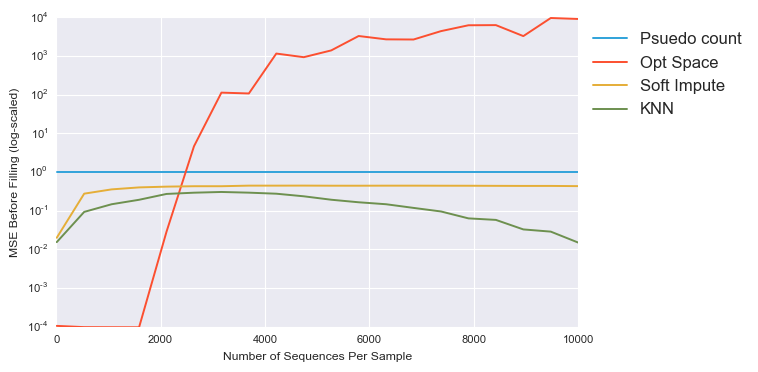

In [41]:
plt.plot(subsample_points,mse_psuedo, label='Psuedo count')
plt.plot(subsample_points,mse_opt, label='Opt Space')
plt.plot(subsample_points,mse_soft, label='Soft Impute')
plt.plot(subsample_points,mse_knn, label='KNN')
plt.legend(loc=2,prop={'size':12},bbox_to_anchor=(1.0, 1.0))
plt.yscale('log')
plt.ylim(0,10000)
plt.ylabel('MSE Before Filling (log-scaled)')
plt.xlabel('Number of Sequences Per Sample')
plt.show()

### Compare MSE between matrix subsampled and method over many levels of overlap [1,50]

In [70]:
%%capture capt
mse=[]
method=[]
ranks=[]
num_seq=[]

for rank_ in range(1,21):
    print('Band overlap'+str(rank_))

    
    ### generate data ### 
    n=100 # number of columns (Samples)
    b=rank_ # number of rows (OTUS)
    # make a mock OTU table
    band=band_diagonal(b=2,n=n)*1000000
    samples,features=band.shape[0],band.shape[1]
    # make a mock df
    X_true=pd.DataFrame(band.T,columns=['sample_'+str(x) for x in range(0,samples)],index=['OTU_'+str(x) for x in range(0,(features))])
    # make a mock mapping data
    mapping=pd.DataFrame(np.array([x for x in range(0,n)]),columns=['example'],index=['sample_'+str(x) for x in range(0,n)])
    #get noise to mimic real datasets 
    X_noise=add_noise(X_true,10,10,10,1)
    X_noise=X_noise.astype(int)

    
    
    subsample_points=[10,1000,10000]
    # sub sample 
    Subsamples_noisy=[]
    for sub_ in subsample_points:

        X_noise_sub=X_noise.copy()
        #sub samples
        for column in X_noise_sub.columns:
            X_noise_sub[column]=subsample_counts(X_noise_sub.astype(int)[column].values, sub_)

        Subsamples_noisy.append(X_noise_sub)
        
        #Complete
        X_recovered_psuedo=[]
        X_recovered_opt=[]
        X_recovered_soft=[]
        X_recovered_knn=[]
        X_recovered_itersvd=[]

        for X_noise_subsampled in Subsamples_noisy:

            #psuedo count
            X_recovered_psuedo.append(X_noise_subsampled+1)

            # OptSpace
            X_filled_opt=complete_matrix(X_noise_subsampled.as_matrix().copy(),rank=30,iteration=15,maxval=1,minval=.01)  
            X_recovered_opt.append(pd.DataFrame(X_filled_opt,X_noise_subsampled.index,X_noise_subsampled.columns))

            # Make 0 NaN for fancy impute 
            X_noisefancy=X_noise_subsampled.copy()
            X_noisefancy[X_noisefancy==0]=np.nan

            # KNN
            X_filled_knn = KNN(k=20,verbose=False,max_value=1,min_value=.01).complete(X_noisefancy)
            X_recovered_knn.append(pd.DataFrame(X_filled_knn,X_noise.index,X_noise.columns))

            #soft impute
            X_filled_softimpute = SoftImpute(verbose=False,max_iters=70,max_value=1,min_value=.01).complete(X_noisefancy)
            X_recovered_soft.append(pd.DataFrame(X_filled_softimpute,X_noise.index,X_noise.columns))

            # Iter SVD
            X_filled_iter=IterativeSVD(verbose=False,max_value=1,min_value=.01).complete(X_noisefancy)
            X_recovered_itersvd.append(pd.DataFrame(X_filled_iter,X_noise.index,X_noise.columns))
            
        #MSE

        for count_,subsampled_with_zeros in enumerate(Subsamples_noisy):

            mse.append(mean_squared_error(subsampled_with_zeros, X_recovered_psuedo[count_]))
            method.append('Psuedo Count')
            ranks.append(rank_)
            num_seq.append(sub_)
            
            mse.append(mean_squared_error(subsampled_with_zeros, X_recovered_opt[count_]))
            method.append('OptSpace')
            ranks.append(rank_)
            num_seq.append(sub_)
            
            
            mse.append(mean_squared_error(subsampled_with_zeros, X_recovered_soft[count_]))
            method.append('Soft Impute')
            ranks.append(rank_)
            num_seq.append(sub_)
            
            mse.append(mean_squared_error(subsampled_with_zeros, X_recovered_knn[count_]))
            method.append('KNN')
            ranks.append(rank_)
            num_seq.append(sub_)
            
            mse.append(mean_squared_error(subsampled_with_zeros, X_recovered_itersvd[count_])) 
            method.append('Iterative SVD')
            ranks.append(rank_)
            num_seq.append(sub_)

In [85]:
plot_all=pd.DataFrame([mse,method,ranks,num_seq],['MSE','Method','Band Overlap','Number of Sequences Per Sample']).T

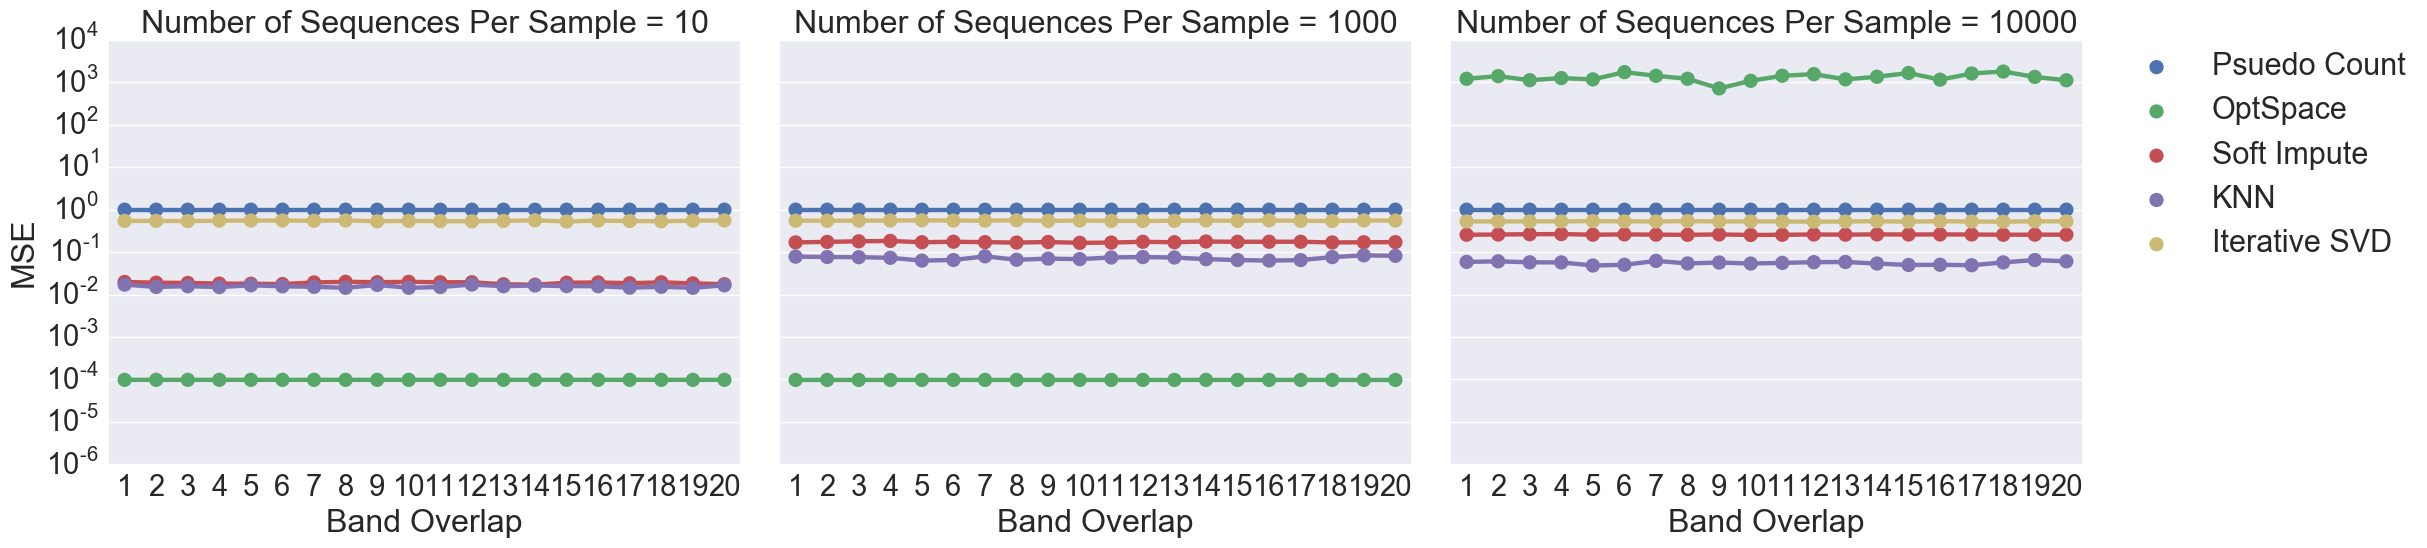

In [97]:
# Draw a pointplot to show pulse as a function of three categorical factors
sns.set(font_scale=2.1)
sns.factorplot(x="Band Overlap", y="MSE", hue="Method", col="Number of Sequences Per Sample", data=plot_all,
                   capsize=.1,ci=None, size=6,alpha=.6, aspect=1.2,legend=False, kind="point")
#despine(left=True)
plt.ylim(10**-6,10**4)
plt.yscale('log')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.,prop={'size':22})
plt.show()